# Projet - Real or Not? NLP with Disaster Tweets

## Project description 

* Competition - https://www.kaggle.com/c/nlp-getting-started

L'objectif de cette compétition Kaggle est de définir les tweet Disaster (catastrohpe). 

In [1]:
#Module installation 

!pip install spacy -q

In [2]:
# Initialization 

#Standard 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

#Model
import tensorflow as tf 
import tensorflow_datasets as tfds
import pathlib 

tf.__version__

'2.6.0'

In [3]:
#Load dataset & Read extract


dataset = pd.read_csv('datasets/desaster_train.csv')

display(dataset.head())
display(dataset.shape)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


(7613, 5)

Les données sont composées de : 
- ID : identifiant unique du tweet
- keyword : Mot-clé à ajouter (si besoin)
- location : Localisation du tweet (peut être vide)
- text : corpus 
- target : Objectif de classification

In [4]:
# Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()
print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Number of rows : 7613

Basics statistics: 


,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000



Percentage of missing values: 


id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

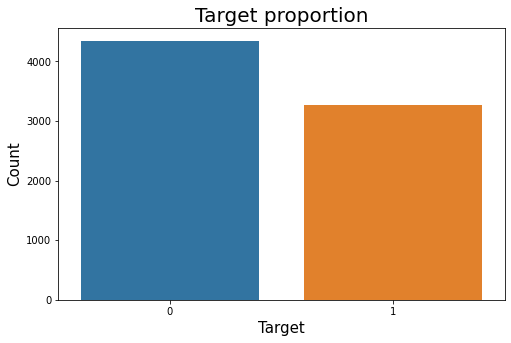

In [5]:
#Dataviz for the targer (proportion)
plt.figure(figsize=(8,5))
sns.countplot(x=dataset['target'])
plt.title('Target proportion',fontsize=20)
plt.xlabel('Target',fontsize=15)
plt.ylabel('Count',fontsize=15);

In [6]:
#Read texts 
display(dataset.loc[0,"text"])
display(dataset.loc[10,"text"])
display(dataset.loc[20,"text"])
display(dataset.loc[30,"text"])
display(dataset.loc[40,"text"])

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

'Three people died from the heat wave so far'

'this is ridiculous....'

'The end!'

'Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw'

In [7]:
#Create dataset with ID, text and target
disaster = dataset.drop(columns=["keyword","location"])
disaster.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
#Check word with "#" and "@"

SYMBOL1 = "#"
words_sym1 = [word for word in disaster["text"] if word.startswith(SYMBOL1)]
display(print(f"# {len(words_sym1)}"))
SYMBOL2 = "@"
words_sym2 = [word for word in disaster["text"] if word.startswith(SYMBOL2)]
display(print(f"@ {len(words_sym2)}"))

# 396


None

@ 1347


None

In [9]:
#Preprocessing NLP (case, html element, special characters)
disaster['text_cleaned'] = disaster['text'].str.lower()
disaster['text_cleaned'] = disaster['text_cleaned'].str.replace(r"<[a-z/]+>", " ") 
disaster['text_cleaned'] = disaster['text_cleaned'].str.replace(r"[^A-Za-z]+", " ")
display(disaster.loc[0,"text_cleaned"])
display(disaster.loc[10,"text_cleaned"])
display(disaster.loc[20,"text_cleaned"])
display(disaster.loc[30,"text_cleaned"])
display(disaster.loc[40,"text_cleaned"])

'our deeds are the reason of this earthquake may allah forgive us all'

'three people died from the heat wave so far'

'this is ridiculous '

'the end '

'check these out http t co roi nsmejj http t co tj zjin http t co yduixefipe http t co lxtjc kls nsfw'

In [10]:
#Tokenization & Lemmatization

import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS 

# tokenization
disaster["text_token"] = disaster['text_cleaned'].fillna('').apply(lambda x: nlp(x))

# remove stop-words
disaster["text_token"] = disaster["text_token"].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])

#Put back tokens into one single string
disaster["text_clean_token"] = [" ".join(x) for x in disaster['text_token']]

disaster.head()

,id,text,target,text_cleaned,text_token,text_clean_token
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[deed, reason, earthquake, allah, forgive]",deed reason earthquake allah forgive
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...,"[ , people, receive, wildfire, evacuation, ord...",people receive wildfire evacuation order cal...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[get, send, photo, ruby, alaska, smoke, wildfi...",get send photo ruby alaska smoke wildfire pour...


In [11]:
#Import tensorflow

import tensorflow as tf
tf.__version__

from tensorflow.keras.layers import (Embedding,
                                     LSTM,
                                     Dense,
                                     Dropout,
                                     GlobalMaxPool1D,
                                     BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

In [12]:
#Encoding
tweets = disaster["text_clean_token"]

VOC_SIZE = 30000
onehot_repr = [one_hot(words, VOC_SIZE) for words in tweets]
onehot_repr[100:110]

[[18288,
  6954,
  18570,
  8944,
  19093,
  4570,
  10726,
  16029,
  24856,
  25023,
  11051,
  16971,
  550],
 [17953,
  10094,
  29718,
  17458,
  17701,
  28103,
  20551,
  10726,
  11337,
  16173,
  6701,
  10827],
 [28275, 22358, 28438, 6871, 13534, 19768, 2805],
 [4416, 22584, 8856, 26738, 21245, 4416, 13538, 5715, 18753],
 [7887,
  10141,
  28275,
  16711,
  11051,
  16971,
  22582,
  25985,
  28369,
  24485,
  16312,
  12480,
  27043,
  7914,
  16711,
  11051,
  16971,
  10060],
 [18197, 17797, 21524, 24037, 21438, 28059, 27228],
 [7887,
  10141,
  28275,
  16711,
  11051,
  16971,
  8507,
  8928,
  25985,
  28369,
  24485,
  16312,
  12480,
  27043,
  7914,
  16711,
  11051,
  16971,
  28924],
 [8874, 17701, 10794, 24275, 4929],
 [28275, 22358, 25686, 11140, 28438, 15774, 24755, 4715, 26738, 6871],
 [11797, 20800, 13504, 13168, 28814, 28185]]

In [13]:
#Padding
SENT_LENGTH = 15
embedded_docs = pad_sequences(onehot_repr, padding="post", maxlen=SENT_LENGTH)
embedded_docs

array([[ 3914, 28289, 25693, ...,     0,     0,     0],
       [ 2146,   530, 24793, ...,     0,     0,     0],
       [27117, 14293, 11978, ...,     0,     0,     0],
       ...,
       [13969, 15989,  6240, ...,     0,     0,     0],
       [17700, 17625,  6093, ..., 16805, 12726, 11516],
       [10342, 26068, 28221, ...,  6725, 20471,     0]], dtype=int32)

In [14]:
#Model 

def create_model():
  VECT_FEATURES = 32
  model = Sequential()
  model.add(Embedding(VOC_SIZE,
                      VECT_FEATURES,
                      input_length=SENT_LENGTH))
  model.add(LSTM(100, return_sequences = True))
  model.add(GlobalMaxPool1D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(10, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = "sigmoid"))
  return model

In [15]:
#Metric & Summary

model = create_model()
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"]) # compiling
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 32)            960000    
_________________________________________________________________
lstm (LSTM)                  (None, 15, 100)           53200     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0

In [16]:
#Target & Lauch model

target = np.array(disaster["target"])
history = model.fit(embedded_docs, target, epochs=6, batch_size=32)

Epoch 1/6
238/238 [==============================] - 10s 11ms/step - loss: 0.5558 - accuracy: 0.7152
Epoch 2/6
238/238 [==============================] - 3s 11ms/step - loss: 0.3524 - accuracy: 0.8563
Epoch 3/6
238/238 [==============================] - 3s 11ms/step - loss: 0.2309 - accuracy: 0.9116
Epoch 4/6
238/238 [==============================] - 3s 11ms/step - loss: 0.1435 - accuracy: 0.9492
Epoch 5/6
238/238 [==============================] - 3s 11ms/step - loss: 0.1140 - accuracy: 0.9589
Epoch 6/6
238/238 [==============================] - 3s 11ms/step - loss: 0.0911 - accuracy: 0.9683


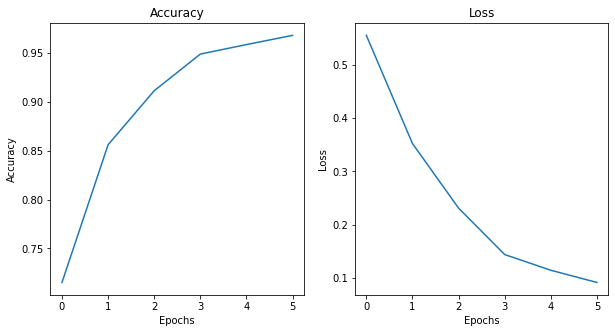

In [17]:
#KPI of model

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(history.history["accuracy"])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")

ax2.plot(history.history["loss"])
ax2.set_title("Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
plt.show()